To open notebook in Colab please click below:
<a href="https://colab.research.google.com/github/bwolfson2/foster_in_dev/blob/master/Module8_Causality/Confounded_analytics_intro.ipynb" target="_parent"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" /> </a>'

In [0]:
#If opening in colab run this cell
!git clone https://github.com/bwolfson2/foster_in_dev
%cd foster_in_dev/Module8_Causality

Cloning into 'foster_in_dev'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 308 (delta 70), reused 158 (delta 31), pack-reused 109
Receiving objects: 100% (308/308), 60.59 MiB | 21.35 MiB/s, done.
Resolving deltas: 100% (109/109), done.
Checking out files: 100% (125/125), done.
/content/foster_in_dev/Module8_Causality


# The problem definition:  Find the best consultant

You work for McKeen Sea, a consulting firm. One of McKeen Sea's oldest and most important customers has requested an additional consultant for a small project, and you've been tasked to find the best one available out of two potential candidates: Aaron and Ben. Fortunately, McKeen Sea has collected some data on the past performance of these consultants, and so you would like to use the data to make a better decision. 

## Get the data and set up your working environment

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


import sys
sys.path.append("..")
from ds_utils.sample_data import get_project_data

data = get_project_data()

# Get a feel for the data

In [3]:
NCOLS    = 6
varnames = data.columns
nvar     = len(data.columns)
# nrows    =  nvar // NCOLS
(nrows,extra)    = divmod(nvar,NCOLS)
if extra:
    nrows +=1


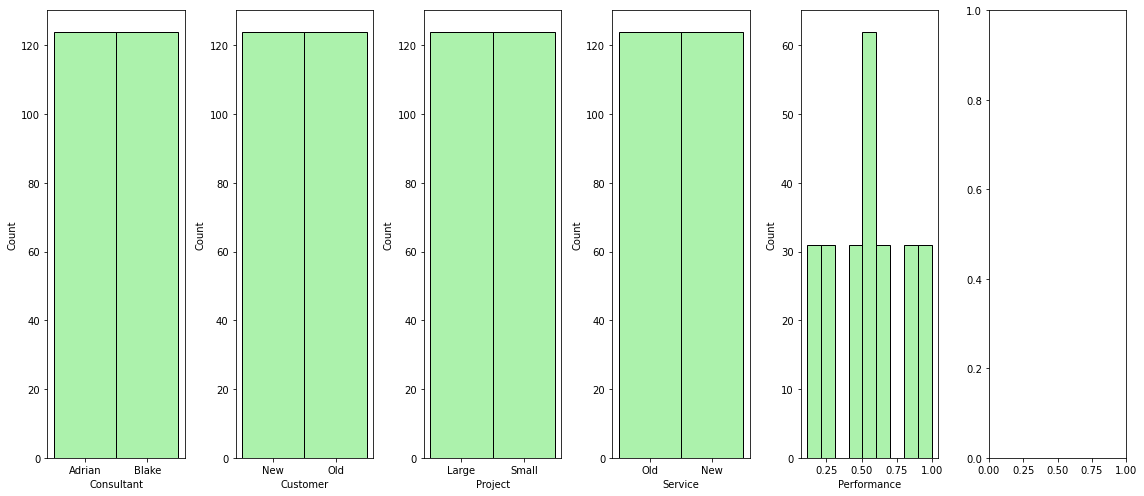

In [4]:
ncols  = NCOLS
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,7*nrows))
for i in range(nvar):
    vn =  varnames[i]
    if nvar <= ncols:
        sns.histplot(data=data, x=vn,ax=axes[i],  color="lightgreen")
    else:
        sns.histplot(data=data, x=vn,ax=axes[i//ncols,i%ncols],  color="lightgreen")
    
fig.tight_layout()
plt.show()

## Hepler plotting functions

In [5]:
# Some auxiliar functions for plotting
def plot_avg_performance(data, groups=None, ncols=2):
    plot_auxiliar(data, groups, True, ncols)
    
def plot_number_of_projects(data, groups=None, ncols=2):
    plot_auxiliar(data, groups, False,ncols)

def plot_auxiliar(data, groups, mean=True,ncols=2):
    n_projects = len(data)
    if groups is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))
        if mean:
            data.groupby(['Consultant']).Performance.mean().plot(kind='bar', rot=0, ax=ax)
            plt.ylabel('Avg. performance')
            plt.ylim((0, 1))
        else:
            data.groupby(['Consultant']).Performance.size().plot(kind='bar', rot=0, ax=ax)
            plt.ylabel('# of projects')
            plt.ylim((0,n_projects))
    else:
        grouped = data.groupby(groups)
        rows = int(grouped.ngroups/2)
        if ncols !=0:
            fig, axs = plt.subplots(figsize=(16,7*rows), nrows=rows, ncols=ncols, gridspec_kw=dict(hspace=0.4))
        targets = zip(grouped.groups.keys(), axs.flatten())
        for i, (key, ax) in enumerate(targets):
            if mean:
                grouped.get_group(key).groupby('Consultant').Performance.mean().plot(kind='bar', rot=0, ax=ax)
                ax.set_ylabel('Avg. performance')
                ax.set_ylim((0, 1))
            else:
                grouped.get_group(key).groupby('Consultant').Performance.size().plot(kind='bar', rot=0, ax=ax)
                ax.set_ylabel('# of projects')
                ax.set_ylim((0,n_projects))
            key_s = []
            if type(key) is not tuple:
                key = (key,)
            for j, elem in enumerate(key):
                key_s.append(elem + ' ' +  groups[j])
            ax.set_title(' | '.join(key_s))

# Analysis

You start with the easiest question: which consultant performs better with old clients?

## Who is better with old clients?

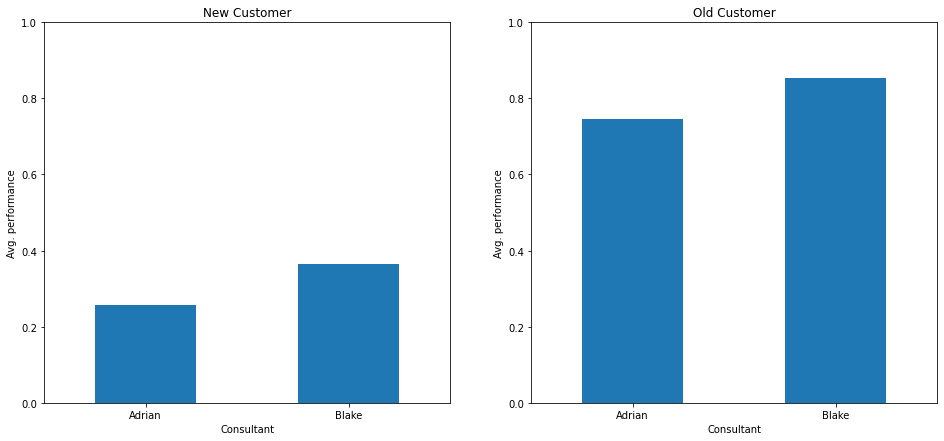

In [6]:
plot_avg_performance(data, groups=['Customer'])

This looks like a no brainer.  **Blake** clearly outperforms Adrian with both new and old clients.  

Can you be confident that Blake will perform better than Adrian? 

Since this is a small project, you'd like to check how the two perform on small projects too.  What happens if we split the data by project size?


## Who is better on small projects?

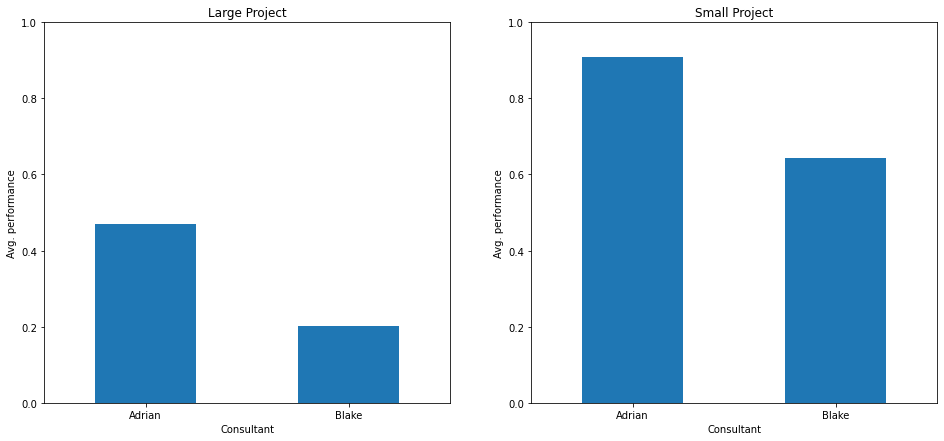

In [7]:
plot_avg_performance(data, groups=['Project'])
plt.show()

Wait a  minute!  The data shows that **Adrian performs better** than Blake, **on both large AND small projects**!  This is the opposite of our finding on customer type.

What the heck is going on in the data??

How is **Adrian's performance WORSE** than Blake **on all project types**, but  **BETTER** than Blake **with all customers**?

## Which assignments are easier and who gets assigned them?

Maybe there is something relating to the nature of the projects and customers that each consultant is assigned...  You decide to take a look.

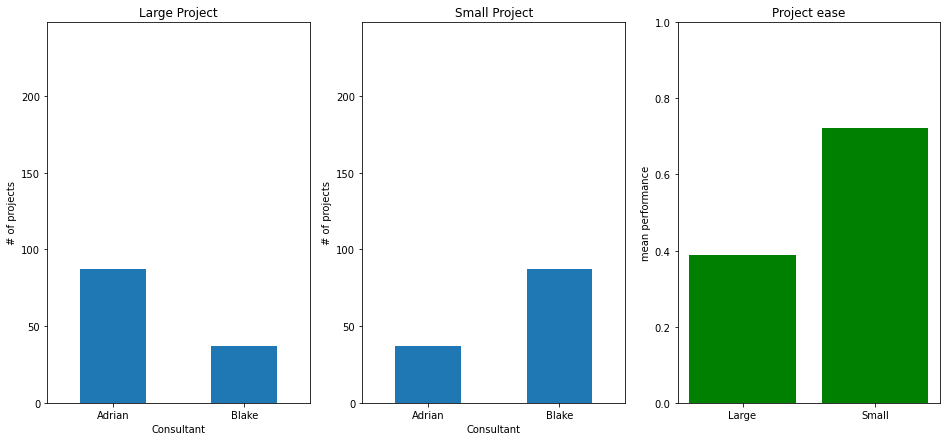

In [8]:
plot_number_of_projects(data, groups=['Project'], ncols=3)

mean_perf_by_project = pd.DataFrame(data.groupby(['Project'])['Performance'].mean())
m = mean_perf_by_project              # for conevenience and readability
plt.bar(m.index, m["Performance"],color=['g'])
plt.title("Project ease")
plt.ylabel("mean performance")
plt.ylim((0,1))
plt.show()


Interesting!  **Blake gets a lot more small projects** than Adrian, and it turns out that **it is generally easier to achieve good performance** on small projects. 

Could something similar be involved with engagements for different kinds of customers?

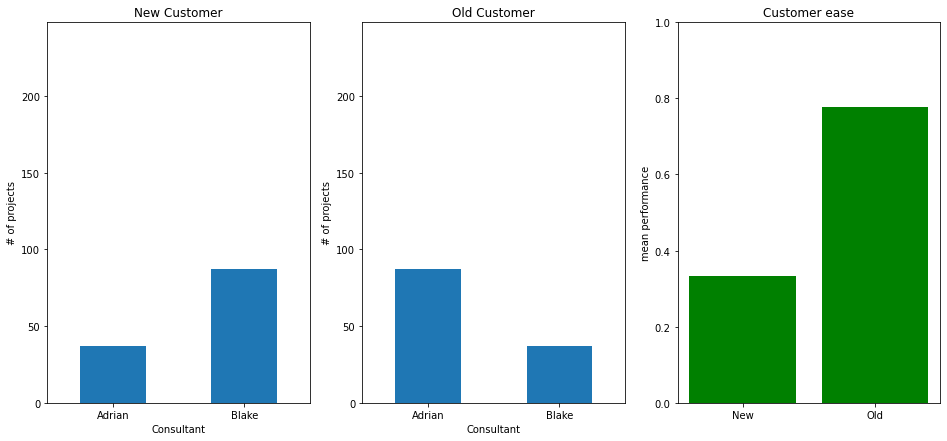

In [10]:
plot_number_of_projects(data, groups=['Customer'], ncols=3)

mean_perf_by_customer = pd.DataFrame(data.groupby(['Customer'])['Performance'].mean())
m = mean_perf_by_customer             # for conevenience and readability
plt.bar(m.index, m["Performance"],color=['g'])
plt.title("Customer ease")
plt.ylabel("mean performance")
plt.ylim((0,1))
plt.show()

From this perspective, it seems that it is Adrian who is getting more of the easy assignments.  **Adrian gets relatively more old customers**, which typically **leads to better performance results**, while Blake gets more of the new clients, which can be more challenging and lead to poorer performance.

Which of these dominates? Is the performance boost from working with old customers better than the performance boost for working on small projects?

Which consultant would you be better off recommending??


Since you are being asked to recommend a consultant to join a small project with an old customer, it makes sense to consider the track record of the consultants in these types of engagements. 

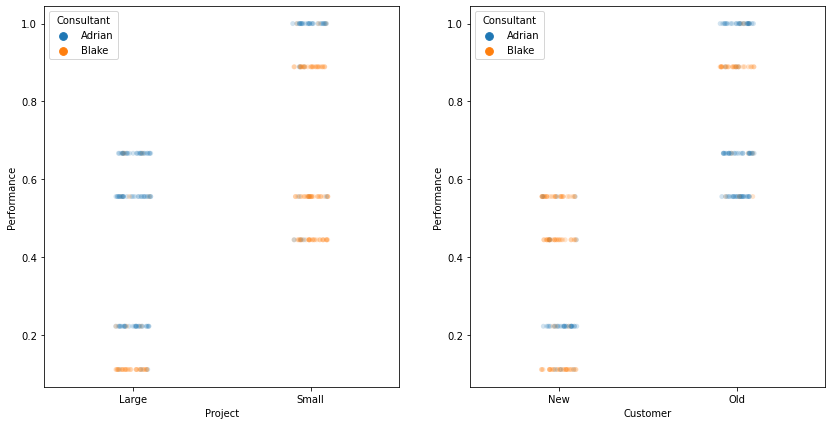

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
cp1=sns.stripplot(ax=axes[0],x="Project", y="Performance",  data=data,hue="Consultant",jitter=True,alpha=0.2)
cp2=sns.stripplot(ax=axes[1],x="Customer", y="Performance", data=data,hue="Consultant",jitter=True,alpha=0.2)
plt.show()

These visualizations add some intuition:  
- The conclusion is clear when we consider project size: Adrian clearly outperforms Blake on all project sizes.
- The picture is more nuanced for old vs new clients.  There, Adrian is sometimes a better performer and sometimes not.

Interestingly, using this set of plots, we can also see that the result we saw earlier, that Adrian has more engagements with old clients and Blake with new, seems to hold up.

## Driving to clarity: The big picture

There is still not a clear direction.  You realize that you really need to examine the data from a multivariate perspective to get to the bottom of the performance quesition.

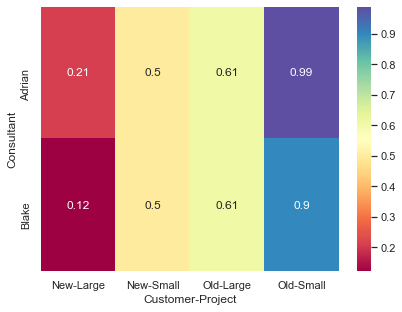

In [75]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.5))
ax=sns.heatmap(xtab,annot=True, cmap="Spectral")
fig.tight_layout()
plt.show()

In [11]:
xtab = pd.crosstab([data.Consultant],[data.Customer, data.Project],values=data.Performance, aggfunc='mean')
xtabm = pd.crosstab([data.Consultant],[data.Customer, data.Project],values=data.Performance, aggfunc='mean',margins=True)
print(np.round(xtabm,2))

Customer     New         Old         All
Project    Large Small Large Small      
Consultant                              
Adrian      0.21   0.5  0.61  0.99  0.60
Blake       0.12   0.5  0.61  0.90  0.51
All         0.17   0.5  0.61  0.94  0.56


Now the mystery is solved.  The seeming paradox was the result of a heterogeneous stream of engagement types on which each consultant worked, and the relative differences in ease and difficulty of those engagements.  Only by examining the data in a multivariate context, and conditioning the data on the specific question you needed to answer, were you able to get to the bottom of this mystery.

This is an example of [*Simpson's Paradox*](https://en.wikipedia.org/wiki/Simpson%27s_paradox), which is a well-known "trap" in data statistics. 

# Recommendation 

After reviewing the multi-dimensional visualizations, it becomes clear that for this assignement, **Adrian** is the better choice.  In fact, Adrian is a better choice in two specific settings.

You should recommend **Adrian** over Blake for:
- Small engagements\with old clients, and 
- Large enagements with new clients. 

For the other engagements, both consultants perform equally.

You pick up the phone and make your recommendation.
